# Solution to Exercise 6: T-type Ca²⁺-channels

The notebook-code below produces 6 figures.

## 1) Soma response
Figure 1 gives the solution to part 1 of the exercise. 

__a)__ With a synaptic weight $w$ = 0.01, the synaptic input triggers a burst in the control model (black curve). 

__b)__ When Na⁺ channels are blocked, the Ca²⁺-spike that the APs in the burst "rode upon" is revealed (red curve). When also T-channels are blocked, the neuron responds passively to the input (blue curve). 

__c)__ We note that before the synapse was activated (at 60 ms), the blue curve is slightly below the red and black curves, i.e. the cell has a lower resting potential in the case when T-channels are blocked. The explanation is that a small fraction of T-channels are open at the resting potential, and give rise to a small inward Ca²⁺ current which depolarizes the cell.


## 2) Dendritic signalling
The solution to part 2 of the exercise is found in Figures 2-4.

__a)__ Fig. 2 shows that the somatic APs only give rise to very small fuctuations in the distal dendrites. However,
the Ca²⁺-spikes are quite well preserved throughout the dendrites, and have roughly the same shape and amplitude in the dendritic endpoints as in the soma. In fact, the response in the distal dendrite is almost unaffected by blocking the Na⁺-channels (Fig. 3). There may be two overlapping explanations to this. (1) Dendrites act as low pass filters. Brief signals (action potentials) are more dampened than more enduring signals (Ca²⁺-spikes). (2) Ca²⁺-spikes do not just travel passively from the soma and out in the dendrites, but are also (partly) generated locally in the dendrites by T-channels that are present there.

__b)__ Fig. 4 shows the response to a synaptic input in the distal dendrite. The local response at the synaptic site is large and peaks at 0 mV (bottom panel). The response in the soma (top panel) is much smaller, and the membrane potential in the soma only increases with about 1 mV. 

__c)__ Signal propagation is evidently more effective in the outward direction. This is generally the case due to the decreasing electronic load (going from the large soma towards gradually thinner structures). When we have active conductances in the dendrites, the answer to this question is less trivial.


## 3) How does the distribution of T-channels affect the neural response properties?
The solution to part 3 of the exercise is found in Figures 5-6.

__a)__ The function `active_conductances` shows how a linearly increasing T-channel density was implemented in the model.

__b)__ 
* When changing from the uniform (Fig. 2) to a distance dependent (Fig. 5) distribution of T-channels, the somatic response to the somatic synapse was reduced. It fired two APs less, and in addition the onset of AP-firing was delayed, since the burst required recruitment of T-channels far away. When changing distributions, we essentially moved T-channels away from the soma-region, thus increasing the average distance between the T-channels and the soma (site of the current injection). A reduction in the local somatic response was what thus expected. 

* Even if the synapse was in the soma and the soma-response was reduced, the distance dependent T-distribution gave a higher response in the distal dendrites compared to the uniform distribution (compare lower panels in Fig. 2 and Fig. 5). The explanation is the high local T-channel density in the distal dendrites. The dendritic response is not solely due to outward propagation of the somatic response, but is partly generated locally by the activation of local T-channels in distal dendrites.

* When the synapse was in the distal dendrite, the distance dependent T-distribution (Fig. 6) gave a larger response than the uniform distribution (Fig. 4) both at the synaptic site (not surprising) and in the soma (maybe surprising).

In summary, we can say that the uniform distribution facilitated the somatic response to somatic current injections, while the distance dependent distribution facilitated the conveyance of signals in both directions between the soma and distal dendrites.

In [1]:
%matplotlib inline
import os
from os.path import join

retval = os.getcwd()
print("Current working directory %s" % retval)
os.chdir("halnes/")
!nrnivmodl
os.chdir(retval)

import numpy as np
import pylab as plt
import scipy.stats
import neuron
from neuron import h
import LFPy

np.random.seed(1234)

Current working directory /Users/geih/Dropbox/Min Mac (Geirs-MacBook-Pro-2.local)/Documents/Undervisning/Exercises_Fys388_2019/Exercise06
/usr/bin/xcrun
/Users/geih/Dropbox/Min Mac (Geirs-MacBook-Pro-2.local)/Documents/Undervisning/Exercises_Fys388_2019/Exercise06/halnes
-n Mod files:
-n  "./Cad.mod"
-n  "./HH_traub.mod"
-n  "./it2.mod"


COBJS=''
 -> Compiling mod_func.c
x86_64-apple-darwin13.4.0-clang -g  -O2 -march=core2 -mtune=haswell -mssse3 -ftree-vectorize -fPIC -fPIE -fstack-protector-strong -O2 -pipe -isystem /Users/geih/opt/anaconda3/envs/lfpy/include -fdebug-prefix-map=/Users/runner/miniforge3/conda-bld/neuron_1621594984609/work=/usr/local/src/conda/neuron-8.0.0 -fdebug-prefix-map=/Users/geih/opt/anaconda3/envs/lfpy=/usr/local/src/conda-prefix  -I.   -I/Users/geih/opt/anaconda3/envs/lfpy/include  -I/Users/geih/opt/anaconda3/envs/lfpy/include -fPIC -c mod_func.c -o mod_func.o
 => LINKING shared library ./libnrnmech.dylib
x86_64-apple-darwin13.4.0-clang++ -g  -O2 -march=core2 

--No graphics will be displayed.


In [2]:
# load active ion channel mechanisms
neuron.load_mechanisms(join("halnes"))

True

In [3]:
def active_conductances(cell, **kwargs):
    rall = 113 # axial resistance
    cap = 1.1 # membrane capacitance
    Rm = 45000.0 # membrane resistance
    Epas = -70.6
    celsius = 36

    ## INSERT ION CHANNELS:
    for sec in h.allsec():
        sec.insert("pas")
        sec.e_pas = Epas
        sec.g_pas = 1/Rm
        sec.Ra = rall
        sec.cm = cap
        sec.insert("Cad")
        sec.insert("it2")
        sec.insert("hh2")
        sec.ena = 50 # Reversal potential for sodium
        sec.ek = -90 # Reversal potential for potassium

     ##################################################################
    # Channel densities
    gna = kwargs["gna"]  # S/cm2
    gkdr = kwargs["gkdr"]
    gcat = kwargs["gcat"]
    tdist = kwargs["tdist"]

    h.celsius = celsius
    for sec in cell.allseclist:
        if sec.name().rfind('soma') >= 0:
            h.distance()
            break

    for sec in cell.allseclist:
        sec.v = Epas
        sec.e_pas = Epas
        sec.insert("pas")
        sec.e_pas = Epas
        sec.g_pas = 1/Rm
        sec.Ra = rall
        sec.cm = cap
        sec.gnabar_hh2 = 0
        sec.gkbar_hh2 = 0
        if sec.name().rfind('soma') >= 0:
            sec.gnabar_hh2 = gna
            sec.gkbar_hh2 = gkdr
    if tdist == 1:
        for sec in cell.allseclist:
            sec.gcabar_it2 = gcat
    if tdist == 2:
        for sec in cell.allseclist:
            if sec.name().rfind('soma') >= 0:
                sec.gcabar_it2 = gcat*0.1054
            else:
                for seg in sec:
                    seg.gcabar_it2 = gcat*0.1054*(1 + 0.04 * h.distance(seg.x,sec=sec))

    if tdist == 3:
        for sec in cell.allseclist:
            sec.gcabar_it2 = gcat
            if sec.name().rfind('soma') >= 0:
                sec.gnabar_hh2 = gna
                sec.gkbar_hh2 = gkdr
            else:
                sec.gnabar_hh2 = gna*0.05
                sec.gkbar_hh2 = gkdr*0.05

def return_interneuron(end_T, dt, start_T, v_init=-75., 
                       gna = 0.18, gkdr = 0.4, gcat = 1.e-4, tdist = 1):

    cell = LFPy.Cell(morphology=join("halnes", "Morf_default.hoc"),
                     dt=dt,
                     tstart=start_T,
                     tstop=end_T,
                     nsegs_method='lambda_f',
                     lambda_f=100,
                     custom_fun=[active_conductances],
                     custom_fun_args=[{'gna': gna, 'gkdr': gkdr, 'gcat': gcat, 'tdist': tdist}],
                     )
    return cell

In [4]:
def insert_synapses(cell, weight, pos):
    '''Insert synapses'''
    
    synapse_params = {
        'idx': pos,
        'e' : 0,                   #reversal potential
        'syntype' : 'Exp2Syn',      #synapse type
        'tau1' : 1,                 #syn time constant
        'tau2' : 3,                 #syn time constant
        'weight' : weight,           #syn weight
        'record_current' : True    #syn current gets recorded
    }

    # Create synapse(s) and setting times using the Synapse class in LFPy
    s = LFPy.Synapse(cell, **synapse_params)
    s.set_spike_times(np.array([60.0]))
    return s

In [5]:
def plot_signal(cell, synapse, synpos, titlestring):
    """
    Plots the somatic membrane potential and somatic transmembrane currents (left), 
    as well as the cell morphology (center), and the extracellular potential (right).
    
    Parameters:
    ===========
    cell : LFPy.Cell object that contains the cell model. This function assumes that the cell simulation is finished
    electrode: Electrode object from the LFPy class RecExtElectrode 
    """
    cell_plot_idx = 0
    fig = plt.figure(figsize=[9, 9])
    fig.subplots_adjust(hspace=0.5)  # Adjusts the vertical distance between panels.
    ax_cell = fig.add_subplot(122, aspect=1)
    ax_cell.axis('off')
    ipos = np.array([0, 65, 110, 128]) # Found by trial and error   
    
    ax_cell.plot(cell.x.T, cell.y.T, c='k')
    
    ax_cell.plot(cell.x.mean(axis=-1)[ipos[0]], cell.y.mean(axis=-1)[ipos[0]], '*', c='k', ms=14)
    ax_cell.plot(cell.x.mean(axis=-1)[ipos[1]], cell.y.mean(axis=-1)[ipos[1]], '*', c='b', ms=14)
    ax_cell.plot(cell.x.mean(axis=-1)[ipos[2]], cell.y.mean(axis=-1)[ipos[2]], '*', c='g', ms=14)
    ax_cell.plot(cell.x.mean(axis=-1)[ipos[3]], cell.y.mean(axis=-1)[ipos[3]], '*', c='r', ms=14)

    if synpos == ipos[0]:
        syncol = 'k'
    elif synpos == ipos[1]:
        syncol = 'b'
    elif synpos == ipos[2]:
        syncol = 'g'
    elif synpos == ipos[3]:
        syncol = 'r'
    else:
        syncol = 'm'

    el, = ax_cell.plot(cell.x.mean(axis=-1)[synpos], cell.y.mean(axis=-1)[synpos], 'd', c=syncol, ms = 16)    
    ax_cell.legend([el], ["Synapse"], frameon=False, loc="lower center")

    ax_v = fig.add_subplot(521, ylabel='mV')
    ax_v.set_title(titlestring)
    ax_v.plot(cell.tvec, cell.somav, color='k', lw=2)
    ax_v = fig.add_subplot(523, ylabel='mV')
    ax_v.plot(cell.tvec, cell.vmem[ipos[1]], color='b', lw=2)
    ax_v = fig.add_subplot(525, ylabel='mV')
    ax_v.plot(cell.tvec, cell.vmem[ipos[2]], color='g', lw=2)
    ax_v = fig.add_subplot(527, xlabel='Time [ms]', ylabel='mV')
    ax_v.plot(cell.tvec, cell.vmem[ipos[3]], color='r', lw=2)
    ax_v = fig.add_subplot(529, xlabel='Time [ms]', ylabel='nA')    
    ax_v.plot(cell.tvec, synapse.i, color= syncol, lw=2)

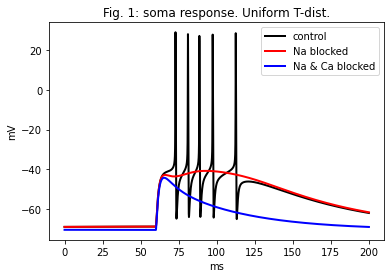

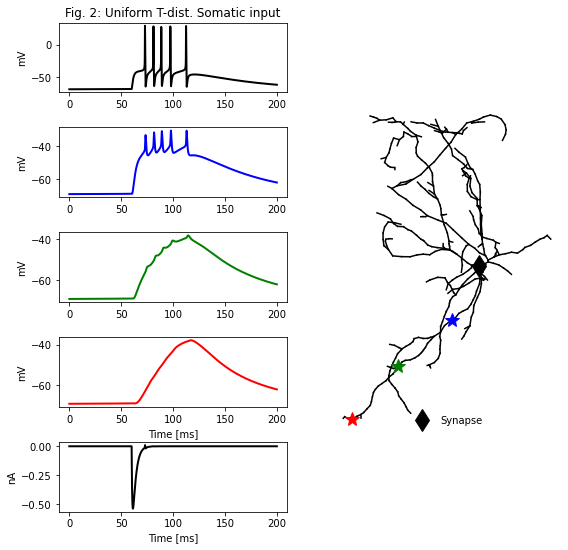

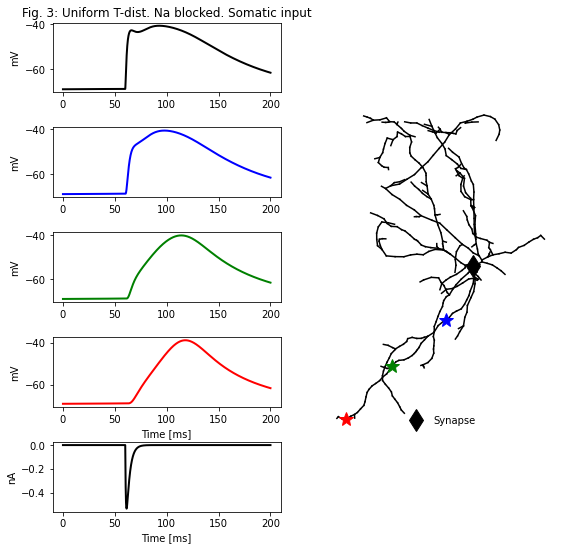

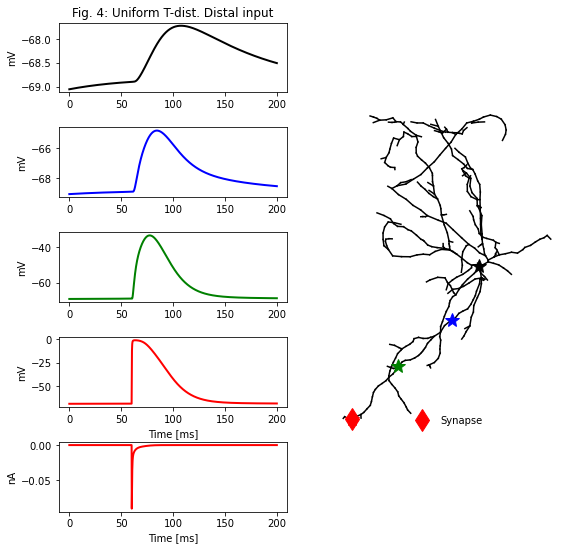

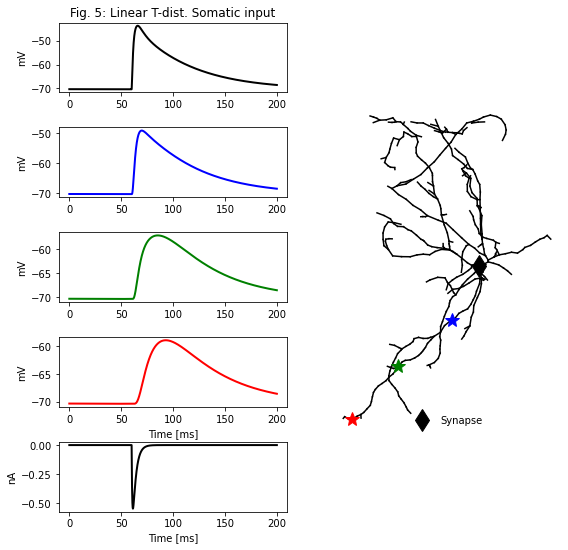

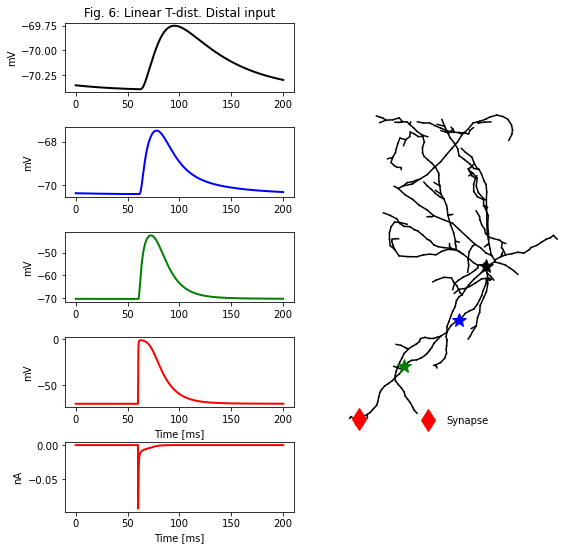

In [6]:
cell_name = "halnes"
weight = 0.01
somapos = 0
distdendpos = 128
closedendpos = 65
fardendpos = 110
        
cell_folder = join(cell_name)
end_T = 200
dt = 2**-5
start_T = -100 
jointfig = plt.figure(figsize=[6, 4])
jax_v = jointfig.add_subplot(111, xlabel='ms', ylabel='mV')
jax_v.set_title('Fig. 1: soma response. Uniform T-dist.')
    
for i in range(1, 7):
    if i == 1:
        titlestring = 'Fig. 2: Uniform T-dist. Somatic input'
        synpos = somapos
        [gnai, gkdri, gcati] = [0.18, 0.4, 1e-4]
        tdisti = 1 # uniform
    if i == 2:
        titlestring = 'Fig. 3: Uniform T-dist. Na blocked. Somatic input'
        synpos = somapos
        [gnai, gkdri, gcati] = [0., 0.4, 1e-4]
        tdisti = 1 # uniform
    if i == 3:
        titlestring = 'Fig. 4: Uniform T-dist. Distal input'
        synpos = distdendpos
        [gnai, gkdri, gcati] = [0.18, 0.4, 1e-4]
        tdisti = 1 # uniform
    if i == 4:
        titlestring = 'Fig. 5: Linear T-dist. Somatic input'
        synpos = somapos
        [gnai, gkdri, gcati] = [0.18, 0.4, 1e-4]
        tdisti = 2 # linear
    if i == 5:
        titlestring = 'Fig. 6: Linear T-dist. Distal input'
        synpos = distdendpos
        [gnai, gkdri, gcati] = [0.18, 0.4, 1e-4]
        tdisti = 2 # linear
    if i == 6:
        #Na & T blocked. Somatic input. No separate figure for this.
        synpos = somapos
        [gnai, gkdri, gcati] = [0, 0.4, 0]      
        tdisti = 1 # uniform
        
    cell = return_interneuron(end_T, dt, start_T, gna=gnai, gkdr=gkdri, gcat=gcati, tdist=tdisti)
    synapse = insert_synapses(cell, weight=weight, pos = synpos)
    cell.simulate(rec_imem=False, rec_vmem=True, synpos = synpos)

    cell.strip_hoc_objects()  # fix crashing kernels with neuron.__version__ >= 7.8
    
    if i == 1:
        jax_v.plot(cell.tvec, cell.somav, label='control', color='k', lw=2)
    if i == 2:
        jax_v.plot(cell.tvec, cell.somav, label='Na blocked', color='r', lw=2)
    if i == 6:
        jax_v.plot(cell.tvec, cell.somav, label='Na & Ca blocked', color='b', lw=2)
        jax_v.legend()
        
    if not i == 6:
        plot_signal(cell, synapse, synpos, titlestring)

## 4) Optional: Dendritic Na⁺ and K⁺ channels
The code below (provided that you have run the previous cell) gives an example solution to the optional exercise 4. For simplicity, dendritic Na⁺ and K⁺ channels was implemented as a third T-distribution (`tdist=3` in `active_conductances`). Here, the distribution of T-channels was the uniform distribution used as default. The Na⁺ and K⁺ channel conductances had the same values as before in the soma. In the dendrites, the Na⁺ and K⁺ were changed from zero (as in the default condition) to values that were 5% of the somatic (original) values. As the figure shows, these relatively low dendritic conductances were sufficient for getting a faithful propagation of somatic APs out into the distal dendrites. 

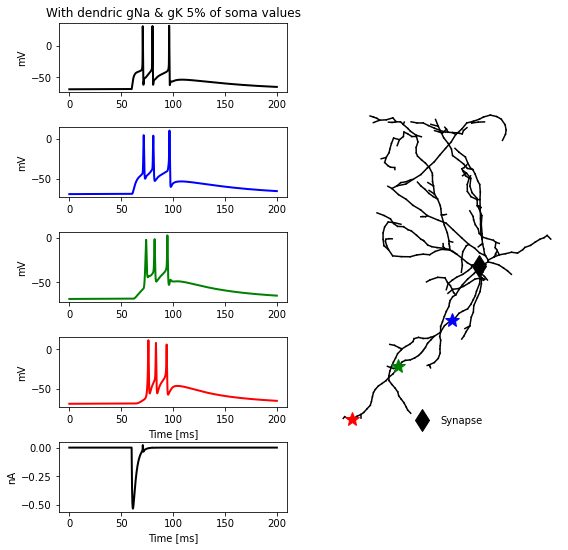

In [7]:
cell = return_interneuron(end_T, dt, start_T, gna=0.18, gkdr=0.4, gcat=1e-4, tdist=3)
synapse = insert_synapses(cell, weight=weight, pos = synpos)
cell.simulate(rec_imem=False, rec_vmem=True, synpos = synpos)
cell.strip_hoc_objects()  # fix crashing kernels with neuron.__version__ >= 7.8
plot_signal(cell, synapse, 0, 'With dendric gNa & gK 5% of soma values')